## Description:

This script computes the confidence intervals of correlation (using equation) and GSS (using bootstrap).

This script creates Figure S5 and S6

In [1]:
import numpy as np
import netCDF4 as nc
import datetime as dt
import pandas as pd
from scipy import stats
import scipy.io as sio
from sklearn.utils import resample

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
import cartopy
import cartopy.crs as ccrs

# for shapefile
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature

%matplotlib inline

In [2]:
rootdir = '/raid1/chen423/serdp/archive/GRL2018/'

In [3]:
# merge all the preparation into one big block, for eacy restart

def get_nc_data(infile, var):
    tmpgroup = nc.Dataset(infile, 'r', format='NETCDF4')
    outdata = tmpgroup.variables[var][:]
    tmpgroup.close()
    return outdata


def split_AR_ns(ARfeature_full):
    # taking 40 as split
    latbound = 40.0
    ARlat = ARfeature_full[:,9]
    nfeatures = ARfeature_full.shape[1]
    nnorth = (ARlat>latbound).sum()
    nsouth = (ARlat<=latbound).sum()
    ARfeature_north = np.zeros((nnorth, nfeatures))
    ARfeature_south = np.zeros((nsouth, nfeatures))
    
    count_n = 0
    count_s = 0
    
    for i in np.arange(ARfeature_full.shape[0]):
        if ARfeature_full[i,9]<=latbound:
            ARfeature_south[count_s,:] = ARfeature_full[i,:]
            count_s = count_s + 1
        elif ARfeature_full[i,9]>latbound:
            ARfeature_north[count_n,:] = ARfeature_full[i,:]
            count_n = count_n + 1
    
    return ARfeature_north, ARfeature_south


def retrieve_ARclass(method):
    file_ffeature = rootdir+'data/AR_features/part2/%s.AR_events_feature.1981-2015.nc' % (method)
    ARfeature_full = get_nc_data(file_ffeature, 'AR_event_feature')
    ARfeature_north, ARfeature_south = split_AR_ns(ARfeature_full)
    
    file_class = rootdir+'data/AR_classification/north_south_split/AR_3class.north.%s.nc' % (method)
    AR_class_index_n = get_nc_data(file_class, 'ARclass_index')
    ARfeature_norm_n = get_nc_data(file_class, 'ARfeature_norm')
    
    file_class = rootdir+'data/AR_classification/north_south_split/AR_3class.south.%s.nc' % (method)
    AR_class_index_s = get_nc_data(file_class, 'ARclass_index')
    ARfeature_norm_s = get_nc_data(file_class, 'ARfeature_norm')
    
    return AR_class_index_n, ARfeature_north, ARfeature_norm_n, AR_class_index_s, ARfeature_south, ARfeature_norm_s


def tindex_to_monthlyindex(index):
    stime = dt.datetime(1981,1,1,0)
    time_delta = dt.timedelta(hours=3*index)
    etime = stime + time_delta
    return (etime.year-1981)*12+etime.month-1  # -1 so it is conssistent with index that starts from 0 in 1981-01


def calc_lag_corraltion(clim_index, indata, lag=0):
    outdata = np.zeros(1080)
    full_len = clim_index.shape[0]
    for i in np.arange(1080):
        outdata[i] = np.corrcoef(clim_index[0:(full_len-lag)], indata[lag:(full_len),i])[0,1]
        
    return outdata


def sub_AR_monthly_nevents(cclass, AR_class_index, ARfeature_fulldata):
    outdata_counts = np.zeros(420)
    
    for i in np.arange(AR_class_index.shape[0]):
        mindex = tindex_to_monthlyindex(ARfeature_fulldata[i,8])
        if cclass=='whole':
            outdata_counts[mindex] = outdata_counts[mindex] + 1
        else:
            if AR_class_index[i]==cclass:
                outdata_counts[mindex] = outdata_counts[mindex] + 1
                
    outdata_sig = outdata_counts.copy()
    outdata_sig[outdata_counts>=1] = 1
    
    return outdata_counts, outdata_sig


def sub_AR_monthly_accum_IntDur(cclass, AR_class_index, ARfeature_fulldata):
    # accumulation of Intensity*Duration
    outdata = np.zeros(420)
    
    for i in np.arange(AR_class_index.shape[0]):
        mindex = tindex_to_monthlyindex(ARfeature_fulldata[i,8])
        if cclass=='whole':
            outdata[mindex] = outdata[mindex] + ARfeature_fulldata[i,3]*ARfeature_fulldata[i,7]
        else:
            if AR_class_index[i]==cclass:
                outdata[mindex] = outdata[mindex] + ARfeature_fulldata[i,3]*ARfeature_fulldata[i,7]
    
    return outdata


def sub_AR_monthly_accum_IntDurAre(cclass, AR_class_index, ARfeature_fulldata):
    # accumulation of Intensity*Duration*Area_land
    outdata = np.zeros(420)
    
    for i in np.arange(AR_class_index.shape[0]):
        mindex = tindex_to_monthlyindex(ARfeature_fulldata[i,8])
        if cclass=='whole':
            outdata[mindex] = outdata[mindex] + ARfeature_fulldata[i,3]*ARfeature_fulldata[i,7]*ARfeature_fulldata[i,1]
        else:
            if AR_class_index[i]==cclass:
                outdata[mindex] = outdata[mindex] + ARfeature_fulldata[i,3]*ARfeature_fulldata[i,7]*ARfeature_fulldata[i,1]
    
    return outdata


def sub_AR_monthly_accum_IntDurWid(cclass, AR_class_index, ARfeature_fulldata):
    # accumulation of Intensity*Duration*Width_coast
    outdata = np.zeros(420)
    
    for i in np.arange(AR_class_index.shape[0]):
        mindex = tindex_to_monthlyindex(ARfeature_fulldata[i,8])
        if cclass=='whole':
            outdata[mindex] = outdata[mindex] + ARfeature_fulldata[i,5]*ARfeature_fulldata[i,7]*ARfeature_fulldata[i,4]
        else:
            if AR_class_index[i]==cclass:
                outdata[mindex] = outdata[mindex] + ARfeature_fulldata[i,5]*ARfeature_fulldata[i,7]*ARfeature_fulldata[i,4]
    
    return outdata


def get_AR_stats(method):
    
    AR_class_index_n, ARfeature_north, ARfeature_norm_n, AR_class_index_s, ARfeature_south, ARfeature_norm_s = retrieve_ARclass(method)
    
    # on the first index:  0 is north, 1 is south
    AR_monthly_nevents = np.zeros((2,420))
    AR_monthly_sig = np.zeros((2,420))
    AR_monthly_nevents[0,:], AR_monthly_sig[0,:] = sub_AR_monthly_nevents('whole', AR_class_index_n, ARfeature_north)
    AR_monthly_nevents[1,:], AR_monthly_sig[1,:] = sub_AR_monthly_nevents('whole', AR_class_index_s, ARfeature_south)

    AR_mon_acc_ida = np.zeros((2,420))
    AR_mon_acc_ida[0,:] = sub_AR_monthly_accum_IntDurAre('whole', AR_class_index_n, ARfeature_north)
    AR_mon_acc_ida[1,:] = sub_AR_monthly_accum_IntDurAre('whole', AR_class_index_s, ARfeature_south)
    
    
    return AR_monthly_nevents, AR_monthly_sig, AR_mon_acc_ida


def sub_AR_daily_sig(cclass, AR_class_index, ARfeature_full, totaldays, lag=0):
    outdata = np.zeros(totaldays)
    for i in np.arange(AR_class_index.shape[0]):
        sindex = (dt.timedelta(hours=3*ARfeature_full[i,6])).days
        eindex = (dt.timedelta(hours=3*(ARfeature_full[i,6])+ARfeature_full[i,7])).days + lag
        if cclass=='whole':
            outdata[sindex:(eindex+1)] = np.ones(np.minimum(eindex-sindex+1, totaldays-sindex))
        else:
            if AR_class_index[i]==cclass:
                outdata[sindex:(eindex+1)] = np.ones(np.minimum(eindex-sindex+1, totaldays-sindex))
                
    return outdata


def calc_extreme_sum_monthly(dailyinput, pvalue):
    print(pvalue)
    tindex_daily = pd.date_range('1/1/1981', periods=dailyinput.shape[0])
    out_count = np.zeros((420,dailyinput.shape[1]))
    for i in np.arange(dailyinput.shape[1]):
        tmpdata = dailyinput[:,i].copy()
        threshold = np.percentile(tmpdata, pvalue*100)
        tmpdata[tmpdata<threshold]='NaN'
        tmpdata_tagged = pd.Series(tmpdata, index=tindex_daily)
        out_count[:,i] = tmpdata_tagged.resample('M').sum()
    return out_count


def calc_extreme_daily_sig(dailyinput, pvalue):
    print(pvalue)
    out_sig = np.zeros(dailyinput.shape)
    for i in np.arange(dailyinput.shape[1]):
        tmpdata = dailyinput[:,i].copy()
        threshold = np.percentile(tmpdata, pvalue*100)
        tmpdata[tmpdata<threshold]=0
        tmpdata[tmpdata>=threshold]=1
        out_sig[:,i] = tmpdata

    return out_sig



def calc_binary_scores(ARdata, hydrodata, metric):

    tmpdata = hydrodata+ARdata
    yy = (tmpdata==2).sum()
    nn = (tmpdata==0).sum()
    
    # yn, ARdata==1, hydrodata==0
    tmpdata = ARdata-hydrodata
    yn = (tmpdata==1).sum()
    ny = (tmpdata==-1).sum()


    if metric=='POD':
        outvalue = yy/(yy + ny)
    elif metric=='FAR':
        outvalue = yn/(yy + yn)
    elif metric=='Bias':
        outvalue = (yy + yn)/(yy + ny)
    elif metric=='HSS':
        outvalue = 2*(yy*nn-yn*ny)/((yy+ny)*(ny+nn)+(yy+yn)*(yn+nn))
    elif metric=='TS':
        outvalue = yy/(yy + ny + yn)
    elif metric=='GSS':
        ets_tmp = (yy + yn)*(yy + ny)/(yy + ny + yn + nn)
        outvalue= (yy - ets_tmp)/(yy + ny + yn - ets_tmp)
                                  
                                  
    return outvalue


dailyP_file = rootdir+'data/hydro_data/WRF/NARR_hist.HUC8.P.nc'
dailyP = get_nc_data(dailyP_file, 'P')


# 95% data
monthly_p95P_sum = calc_extreme_sum_monthly(dailyP, 0.95)

daily_p95P_sig = calc_extreme_daily_sig(dailyP, 0.95)

0.95
0.95


In [4]:
def add_region_divider(axes, ymin, ymax, color, labelflag=False):
    linewidth=0.8
    #axes.plot((12,12), (ymin,ymax), '--', color=color, linewidth=linewidth)
    axes.plot((54,54), (ymin,ymax), '--', color=color, linewidth=linewidth)
    axes.plot((313,313), (ymin,ymax), '--', color=color, linewidth=linewidth)
    axes.plot((406,406), (ymin,ymax), '--', color=color, linewidth=linewidth)
    axes.plot((451,451), (ymin,ymax), '--', color=color, linewidth=linewidth)
    axes.plot((518,518), (ymin,ymax), '--', color=color, linewidth=linewidth)
    axes.plot((578,578), (ymin,ymax), '--', color=color, linewidth=linewidth)
    axes.plot((663,663), (ymin,ymax), '--', color=color, linewidth=linewidth)
    axes.plot((734,734), (ymin,ymax), '--', color=color, linewidth=linewidth)
    axes.plot((954,954), (ymin,ymax), '--', color=color, linewidth=linewidth)
    
    if labelflag==True:
        axes.set_xticks(np.array([30,184,360,429,485,548,621,699,844,1017]))
        axes.set_xticklabels(('SRR', 'Missouri', 'AWR', 'Texas', 'RG', 'UCol', 'LCol', 'GBasin', 'PNW', 'California'), rotation=90)
        axes.set_xlabel('HUC8 basins, grouped by HUC2', size=12)
    else:
        axes.set_xticks([])

In [5]:
def add_region_divider_background(axes, ymax, color, labelflag=False):
    linewidth=0.8
    #axes.plot((12,12), (-2,2), '--', color=color, linewidth=linewidth)
    axes.plot((54,54), (-2,ymax), '--', color=color, linewidth=linewidth)
    axes.plot((313,313), (-2,ymax), '--', color=color, linewidth=linewidth)
    axes.plot((406,406), (-2,ymax), '--', color=color, linewidth=linewidth)
    axes.plot((451,451), (-2,ymax), '--', color=color, linewidth=linewidth)
    axes.plot((518,518), (-2,ymax), '--', color=color, linewidth=linewidth)
    axes.plot((578,578), (-2,ymax), '--', color=color, linewidth=linewidth)
    axes.plot((663,663), (-2,2), '--', color=color, linewidth=linewidth)
    axes.plot((734,734), (-2,2), '--', color=color, linewidth=linewidth)
    axes.plot((954,954), (-2,2), '--', color=color, linewidth=linewidth)
    
    if labelflag==True:
        axes.set_xticks(np.array([30,184,360,429,485,548,621,699,844,1017]))
        axes.set_xticklabels(('SRR', 'Missouri', 'AWR', 'Texas', 'RG', 'UCol', 'LCol', 'GBasin', 'PNW', 'California'), rotation=90)
        axes.set_xlabel('HUC8 basins, grouped by HUC2', size=12)
    else:
        axes.set_xticks([])

## 1. correlation

use standard stats approach

In [6]:
def pearsonr_ci(x,y,alpha=0.05):
    ''' calculate Pearson correlation along with the confidence interval using scipy and numpy
    Parameters
    ----------
    x, y : iterable object such as a list or np.array
      Input for correlation calculation
    alpha : float
      Significance level. 0.05 by default
    Returns
    -------
    r : float
      Pearson's correlation coefficient
    pval : float
      The corresponding p value
    lo, hi : float
      The lower and upper bound of confidence intervals
    '''

    r, p = stats.pearsonr(x,y)
    r_z = np.arctanh(r)
    se = 1/np.sqrt(x.size-3)
    z = stats.norm.ppf(1-alpha/2)
    lo_z, hi_z = r_z-z*se, r_z+z*se
    lo, hi = np.tanh((lo_z, hi_z))
    return r, p, lo, hi

In [7]:
se = 1/np.sqrt(420-3)
z = stats.norm.ppf(1-0.025/2)
print(z*se)

0.10976196380621508


In [8]:
def calc_lag_corr_with_CI(clim_index, indata, lag=0, alpha=0.05, flag=None):
    outdata = np.zeros((1080,4))
    full_len = clim_index.shape[0]
    for i in np.arange(1080):
        r, p, r_lower, r_upper = pearsonr_ci(clim_index[0:(full_len-lag)], indata[lag:(full_len),i], alpha=alpha)
        outdata[i,0] = r
        outdata[i,1] = p
        outdata[i,2] = r-r_lower
        if p<=alpha: # significant
            if flag=='n':
                outdata[i,3] = 1
            if flag=='s':
                outdata[i,3] = -1
        else:  # non-significant
            outdata[i,3] = 0
    return outdata

In [9]:
Pdata = monthly_p95P_sum

def derive_corr_with_CI(method):

    AR_monthly_nevents, AR_monthly_sig, AR_mon_acc_ida = get_AR_stats(method)
    corrdata_raw = np.zeros((1080,4,2))
    corrdata_raw[:,:,0] = calc_lag_corr_with_CI(AR_mon_acc_ida[0], Pdata, alpha=0.05, flag='n')
    corrdata_raw[:,:,1] = calc_lag_corr_with_CI(AR_mon_acc_ida[1], Pdata, alpha=0.05, flag='s')
    
    return corrdata_raw

In [10]:
def generate_plot_segment(method):
    x = np.arange(1080)
    corrdata_raw = derive_corr_with_CI(method)
    # north
    y = corrdata_raw[:,0,0]
    z = corrdata_raw[:,1,0]
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    lc_north = LineCollection(segments, cmap=cmap_north, norm=norm)
    lc_north.set_array(z)
    lc_north.set_linewidth(0.6)
    # south
    y = corrdata_raw[:,0,1]
    z = corrdata_raw[:,1,1]
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    lc_south = LineCollection(segments, cmap=cmap_south, norm=norm)
    lc_south.set_array(z)
    lc_south.set_linewidth(0.6)
    return lc_north, lc_south

In [11]:
cmap_north = ListedColormap(['blue', 'blue'])
cmap_south = ListedColormap(['red', 'red'])
norm = BoundaryNorm([0,0.05,1], cmap_north.N)

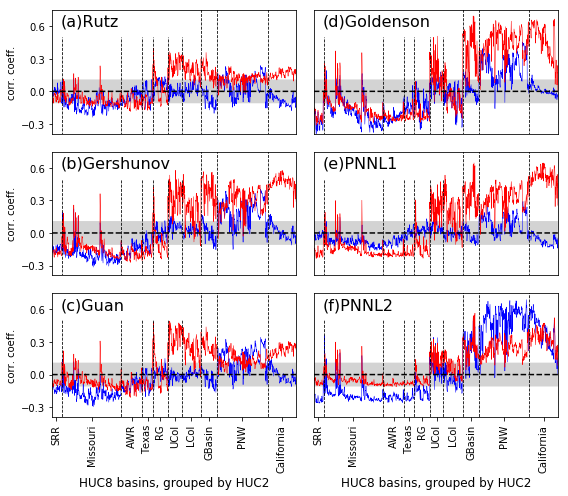

In [12]:
fig1 = plt.figure(figsize=(8,7))

# rutz
ax1 = plt.subplot(3,2,1)
#lc_north, lc_south = generate_plot_segment('rutz')
#ax1.add_collection(lc_north)
#ax1.add_collection(lc_south)
corrdata_raw = derive_corr_with_CI('rutz')
ax1.plot(corrdata_raw[:,0,0], color='blue', linewidth=0.5)
ax1.plot(corrdata_raw[:,0,1], color='red', linewidth=0.5)
ax1.plot(np.arange(1080), np.zeros(1080), color='black', linestyle='--')
ax1.set_xlim([12, 1080])
ax1.set_ylim([-0.39,0.75])
add_region_divider_background(ax1, 0.5, 'black')

# gerhsunov
ax2 = plt.subplot(3,2,3)
#lc_north, lc_south = generate_plot_segment('gershunov')
#ax2.add_collection(lc_north)
#ax2.add_collection(lc_south)
corrdata_raw = derive_corr_with_CI('gershunov')
ax2.plot(corrdata_raw[:,0,0], color='blue', linewidth=0.5)
ax2.plot(corrdata_raw[:,0,1], color='red', linewidth=0.5)
ax2.plot(np.arange(1080), np.zeros(1080), color='black', linestyle='--')
ax2.set_xlim([12, 1080])
ax2.set_ylim([-0.39,0.75])
add_region_divider_background(ax2, 0.5, 'black')

# guan
ax3 = plt.subplot(3,2,5)
#lc_north, lc_south = generate_plot_segment('guan')
#ax3.add_collection(lc_north)
#ax3.add_collection(lc_south)
corrdata_raw = derive_corr_with_CI('guan')
ax3.plot(corrdata_raw[:,0,0], color='blue', linewidth=0.5)
ax3.plot(corrdata_raw[:,0,1], color='red', linewidth=0.5)
ax3.plot(np.arange(1080), np.zeros(1080), color='black', linestyle='--')
ax3.set_xlim([12, 1080])
ax3.set_ylim([-0.39,0.75])
add_region_divider_background(ax3, 0.5, 'black', labelflag=True)

# goldenson
ax4 = plt.subplot(3,2,2)
#lc_north, lc_south = generate_plot_segment('goldenson')
#ax4.add_collection(lc_north)
#ax4.add_collection(lc_south)
corrdata_raw = derive_corr_with_CI('goldenson')
ax4.plot(corrdata_raw[:,0,0], color='blue', linewidth=0.5)
ax4.plot(corrdata_raw[:,0,1], color='red', linewidth=0.5)
ax4.plot(np.arange(1080), np.zeros(1080), color='black', linestyle='--')
ax4.set_xlim([12, 1080])
ax4.set_ylim([-0.39,0.75])
add_region_divider_background(ax4, 0.5, 'black')
ax4.set_yticks([])

# pnnl1
ax5 = plt.subplot(3,2,4)
#lc_north, lc_south = generate_plot_segment('pnnl1')
#ax5.add_collection(lc_north)
#ax5.add_collection(lc_south)
corrdata_raw = derive_corr_with_CI('pnnl1')
ax5.plot(corrdata_raw[:,0,0], color='blue', linewidth=0.5)
ax5.plot(corrdata_raw[:,0,1], color='red', linewidth=0.5)
ax5.plot(np.arange(1080), np.zeros(1080), color='black', linestyle='--')
ax5.set_xlim([12, 1080])
ax5.set_ylim([-0.39,0.75])
add_region_divider_background(ax5, 0.5, 'black')
ax5.set_yticks([])

# pnnl2
ax6 = plt.subplot(3,2,6)
#lc_north, lc_south = generate_plot_segment('pnnl2')
#ax6.add_collection(lc_north)
#ax6.add_collection(lc_south)
corrdata_raw = derive_corr_with_CI('pnnl2')
ax6.plot(corrdata_raw[:,0,0], color='blue', linewidth=0.5)
ax6.plot(corrdata_raw[:,0,1], color='red', linewidth=0.5)
ax6.plot(np.arange(1080), np.zeros(1080), color='black', linestyle='--')
ax6.set_xlim([12, 1080])
ax6.set_ylim([-0.39,0.75])
add_region_divider_background(ax6, 0.5, 'black', labelflag=True)
ax6.set_yticks([])

for axis in [ax1,ax2,ax3,ax4,ax5,ax6]:
    axis.fill_between(np.arange(1080), np.ones(1080)*-0.1097, np.ones(1080)*0.1097, facecolor='lightgray', alpha=1)

ax1.set_yticks([-0.3, 0, 0.3, 0.6])
ax2.set_yticks([-0.3, 0, 0.3, 0.6])
ax3.set_yticks([-0.3, 0, 0.3, 0.6])

ax1.set_ylabel('corr. coeff.')
ax2.set_ylabel('corr. coeff.')
ax3.set_ylabel('corr. coeff.')

ax1.text(50,0.6, '(a)Rutz', size=16)
ax2.text(50,0.6, '(b)Gershunov', size=16)
ax3.text(50,0.6, '(c)Guan', size=16)
ax4.text(50,0.6, '(d)Goldenson', size=16)
ax5.text(50,0.6, '(e)PNNL1', size=16)
ax6.text(50,0.6, '(f)PNNL2', size=16)

plt.tight_layout()

#fig1.savefig(rootdir+'plots/figS6.png', dpi=600)
plt.show()
plt.close()
del(fig1)

## 2. GSS

take bootstrap approach to estimate CI


### 2.1  If it has not been computed, compute them here.

In [13]:
def calc_binary_score_with_nootstrapCI(clim_index, indata, epochs=1000, alpha=0.05, flag=None):
    # outdata: [score, lowerbound_score, upperbound_score, significantly positive?, 50% value]
    outdata = np.zeros((1080,5))
    full_len = clim_index.shape[0]
    for i in np.arange(1080):
        #print(i)
        score_array = np.zeros(epochs)
        for j in np.arange(epochs):
            bs_AR, bs_data = resample(clim_index, indata[:,i])
            score_array[j] = calc_binary_scores(bs_AR, bs_data, 'GSS')
        outdata[i,0] = calc_binary_scores(clim_index, indata[:,i], 'GSS')
        outdata[i,1] = np.percentile(score_array, (alpha/2)*100)
        outdata[i,2] = np.percentile(score_array, (1-alpha/2)*100)
        outdata[i,4] = np.percentile(score_array, 50)
        if flag=='n':
            outdata[:,3][outdata[:,1]>0]=1
        if flag=='s':
            outdata[:,3][outdata[:,1]>0]=-1
    return outdata

In [14]:
def derive_GSS_with_CI(method):
    AR_class_index_n, ARfeature_north, ARfeature_norm_n, AR_class_index_s, ARfeature_south, ARfeature_norm_s = retrieve_ARclass(method)
    AR_daily_sig_n = sub_AR_daily_sig('whole', AR_class_index_n, ARfeature_north, totaldays, lag=0)
    AR_daily_sig_s = sub_AR_daily_sig('whole', AR_class_index_s, ARfeature_south, totaldays, lag=0)
    GSSdata = np.zeros((1080,5,2))
    GSSdata[:,:,0] = calc_binary_score_with_nootstrapCI(AR_daily_sig_n, daily_p95P_sig, alpha=0.05, flag='n')
    GSSdata[:,:,1] = calc_binary_score_with_nootstrapCI(AR_daily_sig_s, daily_p95P_sig, alpha=0.05, flag='s')
    return GSSdata

In [15]:
totaldays = dailyP.shape[0]

In [ ]:
GSS_rutz = derive_GSS_with_CI('rutz')
GSS_gershunov = derive_GSS_with_CI('gershunov')
GSS_guan = derive_GSS_with_CI('guan')
GSS_goldenson = derive_GSS_with_CI('goldenson')
GSS_pnnl1 = derive_GSS_with_CI('pnnl1')
GSS_pnnl2 = derive_GSS_with_CI('pnnl2')

In [ ]:
#sio.savemat(rootdir+'data/intermediate_data/P_GSS_95CI.mat', {'GSS_rutz':GSS_rutz, 'GSS_gershunov':GSS_gershunov, 'GSS_guan':GSS_guan,
#                 'GSS_goldenson':GSS_goldenson, 'GSS_pnnl1':GSS_pnnl1, 'GSS_pnnl2':GSS_pnnl2})

### 2.2 alternatively, if data is already saved, just retrieve them

In [17]:
datafile = rootdir+'data/intermediate_data/P_GSS_95CI.mat'
GSS_rutz = sio.loadmat(datafile)['GSS_rutz']
GSS_gershunov = sio.loadmat(datafile)['GSS_gershunov']
GSS_guan = sio.loadmat(datafile)['GSS_guan']
GSS_goldenson = sio.loadmat(datafile)['GSS_goldenson']
GSS_pnnl1 = sio.loadmat(datafile)['GSS_pnnl1']
GSS_pnnl2 = sio.loadmat(datafile)['GSS_pnnl2']

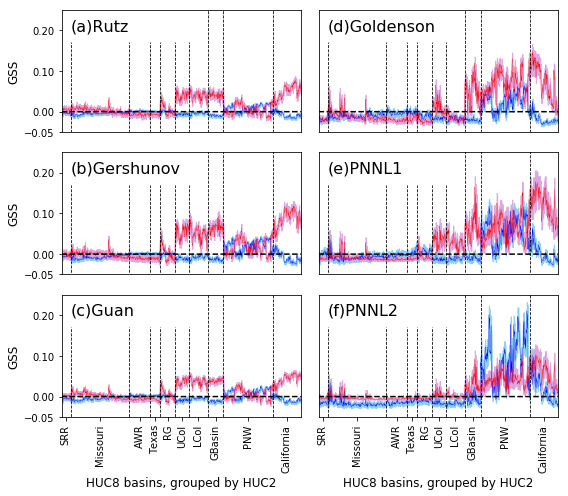

In [18]:
fig2 = plt.figure(figsize=(8,7))

# rutz
GSSdata = GSS_rutz
ax1 = plt.subplot(3,2,1)
ax1.plot(np.arange(1080), GSSdata[:,0,0], color='blue', linewidth=0.3, alpha=1)
ax1.plot(np.arange(1080), GSSdata[:,0,1], color='red', linewidth=0.3, alpha=1)
ax1.plot(np.arange(1080), np.zeros(1080), color='black', linestyle='--')
ax1.fill_between(np.arange(1080), GSSdata[:,2,0], GSSdata[:,1,0], color='skyblue', alpha=0.9)
ax1.fill_between(np.arange(1080), GSSdata[:,2,1], GSSdata[:,1,1],color='plum', alpha=0.9)
ax1.set_xlim([12, 1080])
ax1.set_ylim([-0.05,0.25])
add_region_divider_background(ax1, 0.17, 'black')


# gerhsunov
GSSdata = GSS_gershunov
ax2 = plt.subplot(3,2,3)
ax2.plot(np.arange(1080), GSSdata[:,0,0], color='blue', linewidth=0.3, alpha=1)
ax2.plot(np.arange(1080), GSSdata[:,0,1], color='red', linewidth=0.3, alpha=1)
ax2.plot(np.arange(1080), np.zeros(1080), color='black', linestyle='--')
ax2.fill_between(np.arange(1080), GSSdata[:,2,0], GSSdata[:,1,0], color='skyblue', alpha=0.9)
ax2.fill_between(np.arange(1080), GSSdata[:,2,1], GSSdata[:,1,1],color='plum', alpha=0.9)
ax2.set_xlim([12, 1080])
ax2.set_ylim([-0.05,0.25])
add_region_divider_background(ax2, 0.17, 'black')


# guan
GSSdata = GSS_guan
ax3 = plt.subplot(3,2,5)
ax3.plot(np.arange(1080), GSSdata[:,0,0], color='blue', linewidth=0.3, alpha=1)
ax3.plot(np.arange(1080), GSSdata[:,0,1], color='red', linewidth=0.3, alpha=1)
ax3.plot(np.arange(1080), np.zeros(1080), color='black', linestyle='--')
ax3.fill_between(np.arange(1080), GSSdata[:,2,0], GSSdata[:,1,0], color='skyblue', alpha=0.9)
ax3.fill_between(np.arange(1080), GSSdata[:,2,1], GSSdata[:,1,1],color='plum', alpha=0.9)
ax3.set_xlim([12, 1080])
ax3.set_ylim([-0.05,0.25])
add_region_divider_background(ax3, 0.17, 'black', labelflag=True)


# goldenson
GSSdata = GSS_goldenson
ax4 = plt.subplot(3,2,2)
ax4.plot(np.arange(1080), GSSdata[:,0,0], color='blue', linewidth=0.3, alpha=1)
ax4.plot(np.arange(1080), GSSdata[:,0,1], color='red', linewidth=0.3, alpha=1)
ax4.plot(np.arange(1080), np.zeros(1080), color='black', linestyle='--')
ax4.fill_between(np.arange(1080), GSSdata[:,2,0], GSSdata[:,1,0], color='skyblue', alpha=0.9)
ax4.fill_between(np.arange(1080), GSSdata[:,2,1], GSSdata[:,1,1],color='plum', alpha=0.9)
ax4.set_xlim([12, 1080])
ax4.set_ylim([-0.05,0.25])
ax4.set_yticks([])
add_region_divider_background(ax4, 0.17, 'black')

# pnnl1
GSSdata = GSS_pnnl1
ax5 = plt.subplot(3,2,4)
ax5.plot(np.arange(1080), GSSdata[:,0,0], color='blue', linewidth=0.3, alpha=1)
ax5.plot(np.arange(1080), GSSdata[:,0,1], color='red', linewidth=0.3, alpha=1)
ax5.plot(np.arange(1080), np.zeros(1080), color='black', linestyle='--')
ax5.fill_between(np.arange(1080), GSSdata[:,2,0], GSSdata[:,1,0], color='skyblue', alpha=0.9)
ax5.fill_between(np.arange(1080), GSSdata[:,2,1], GSSdata[:,1,1],color='plum', alpha=0.9)
ax5.set_xlim([12, 1080])
ax5.set_ylim([-0.05,0.25])
ax5.set_yticks([])
add_region_divider_background(ax5, 0.17, 'black')

# pnnl2
GSSdata = GSS_pnnl2
ax6 = plt.subplot(3,2,6)
ax6.plot(np.arange(1080), GSSdata[:,0,0], color='blue', linewidth=0.3, alpha=1)
ax6.plot(np.arange(1080), GSSdata[:,0,1], color='red', linewidth=0.3, alpha=1)
ax6.plot(np.arange(1080), np.zeros(1080), color='black', linestyle='--')
ax6.fill_between(np.arange(1080), GSSdata[:,2,0], GSSdata[:,1,0], color='skyblue', alpha=0.9)
ax6.fill_between(np.arange(1080), GSSdata[:,2,1], GSSdata[:,1,1],color='plum', alpha=0.9)
ax6.set_xlim([12, 1080])
ax6.set_ylim([-0.05,0.25])
ax6.set_yticks([])
add_region_divider_background(ax6, 0.17, 'black', labelflag=True)

ax1.set_yticks([-0.05, 0, 0.1, 0.2])
ax2.set_yticks([-0.05, 0, 0.1, 0.2])
ax3.set_yticks([-0.05, 0, 0.1, 0.2])

ax1.set_ylabel('GSS', size=12)
ax2.set_ylabel('GSS', size=12)
ax3.set_ylabel('GSS', size=12)

ax1.text(50,0.2, '(a)Rutz', size=16)
ax2.text(50,0.2, '(b)Gershunov', size=16)
ax3.text(50,0.2, '(c)Guan', size=16)
ax4.text(50,0.2, '(d)Goldenson', size=16)
ax5.text(50,0.2, '(e)PNNL1', size=16)
ax6.text(50,0.2, '(f)PNNL2', size=16)

plt.tight_layout()

#fig2.savefig(rootdir+'plots/figS5.png', dpi=600)
plt.show()
plt.close()
del(fig2)